# Preprocessing

This script performs basic preprocessing steps for a customer churn dataset.  
It includes:

- Handling missing values using the median.
- Optionally removing outliers using the IQR method.
- Encoding categorical variables with `OrdinalEncoder`.
- Saving the cleaned data as a pickle file (`clean_data.pkl`).

Set the global flags `DEBUG` and `REMOVE_OUTLIERS` to control logging and outlier removal.

Run this cell to preprocess the data and prepare it for modeling.


In [1]:
%%writefile preprocess.py

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder


DEBUG = False
REMOVE_OUTLIERS = False
TARGET = "Churn"


def determine_outlier_thresholds_iqr(df, col_name, th1=0.25, th3=0.75):
    # for removing outliers using Interquartile Range or IQR
    quartile1 = df[col_name].quantile(th1)
    quartile3 = df[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

def print_missing_values_table(data, na_name=False):
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def preprocess_df(data):
    print('\nPreprocessing data...')
    target = TARGET
    total_rows_number = data.shape[0]

    columns = data.columns.to_list()

    if DEBUG:
        print(f'Total rows: {total_rows_number}, unique {col}s: {data[col].nunique()}')
    data.drop('CustomerID', axis=1, inplace=True)

    nan_cols = data.columns[data.isnull().any()].to_list()

    if DEBUG and nan_cols:
        print(f'\nColumns with nulls:\n{nan_cols}')
        print_missing_values_table(data, na_name=True)

    # fix missing values - fill with median values
    if nan_cols:
        if DEBUG:
            print(f'\nFixing missing values...')
        data.loc[:, nan_cols] = data.loc[:, nan_cols].fillna(data.loc[:, nan_cols].median())

    if DEBUG:
        nan_cols = data.columns[data.isnull().any()].to_list()
        print(f' Any columns with nulls left? {nan_cols}')

    if REMOVE_OUTLIERS:
      # print(f"\nRemoving {col} outliers using the Standard deviation method")
      # lower, upper = determine_outlier_thresholds_sdm(data, col, 6) # 4
      # print(" upper limit:", upper)
      # print(" lower limit:", lower)
      print(f"\nRemoving Tenure outliers using IQR")
      lower, upper = determine_outlier_thresholds_iqr(data, 'Tenure', th1=0.05, th3=0.95)
      print(" upper limit:", upper)
      print(" lower limit:", lower)
      data = data[(data['Tenure'] >= lower) & (data['Tenure'] <= upper)]

    print(
        f'\nFinal number of records: {data.shape[0]} / {total_rows_number} =',
        f'{data.shape[0]/total_rows_number*100:05.2f}%\n',
    )
    return data

def preprocess_data(df, ord_enc, fit_enc=False):
    # fix missing values, remove outliers
    df = preprocess_df(df)

    # encode categorical
    categorical_features = df.select_dtypes(exclude=[np.number]).columns
    if len(categorical_features):
        if DEBUG:
            print('OrdinalEncoder categorical_features:', list(categorical_features))
        # import ordinal encoder from sklearn
        # ord_enc = OrdinalEncoder()
        if fit_enc:
            # Fit and Transform the data
            df[categorical_features] = ord_enc.fit_transform(df[categorical_features])
            df.to_pickle('clean_data.pkl')
            if DEBUG:
                print(' OrdinalEncoder categories:', ord_enc.categories_)
        else:
            # Only Transform the data (using pretrained encoder)
            df[categorical_features] = ord_enc.transform(df[categorical_features])

    columns = df.columns.to_list()
    if DEBUG and TARGET in columns and len(df) > 10:
        corr = df.corr(numeric_only=True)[TARGET]
        print(f'\nCorrelation-2 to {TARGET}:\n{corr.to_string()}')

    return df


if __name__ == '__main__':

  df = pd.read_csv('E Commerce Dataset.xlsx.csv')

  ord_enc = OrdinalEncoder()
  df = preprocess_data(df, ord_enc, fit_enc=True)


Overwriting preprocess.py


In [2]:
!python3 preprocess.py


Preprocessing data...

Final number of records: 5630 / 5630 = 100.00%



# Definition of the Architecture Class

This script defines the `Architecture` class, a complete abstraction for training PyTorch models in a structured and flexible way. The class encapsulates:

- **Initialization with model, loss function, and optimizer**;
- **Device management (CPU/GPU)**;
- **Setup of training and validation data loaders**;
- **Mini-batch training and per-epoch validation**;
- **Checkpoint saving and loading**;
- **Prediction generation and loss visualization**.

The structure is designed to facilitate rapid prototyping and code reusability for supervised learning tasks using PyTorch.

It also includes utilities to ensure **reproducibility** via `set_seed`, device handling with `to()`, and helper functions to **plot loss curves**.


In [3]:
%%writefile architecture.py

import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

Overwriting architecture.py


# Definition of the Trainer Class

This script defines the `Trainer` class, which serves as a high-level wrapper to streamline the full machine learning pipeline for binary classification using PyTorch.

The class provides:

- **Data loading** from a serialized `.pkl` file (assumes the target column is `"Churn"`),
- **Preprocessing** with `StandardScaler` and train/test split using `train_test_split`,
- **DataLoader construction** for both training and validation sets using PyTorch tensors,
- **Model building** using a simple linear layer followed by a binary cross-entropy loss,
- **Training** using the `Architecture` abstraction (imported from `architecture.py`),
- **Scalability and reproducibility** via seed setting and parameter initialization.

This class encapsulates the full training workflow and returns a trained `Architecture` instance and the fitted `StandardScaler`.


In [4]:
%%writefile trainer.py

import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from architecture import Architecture

class Trainer:
    def __init__(self, data_path='clean_data.pkl', batch_size=64, lr=0.05, test_size=0.2, seed=42):
        self.data_path = data_path
        self.batch_size = batch_size
        self.lr = lr
        self.test_size = test_size
        self.seed = seed

        self.scaler = None
        self.model = None
        self.optimizer = None
        self.loss_fn = None
        self.train_loader = None
        self.val_loader = None
        self.arch = None

    def load_data(self):
        with open(self.data_path, 'rb') as f:
            df = pickle.load(f)
        X = df.drop(columns=["Churn"]).values
        y = df["Churn"].values
        return X, y

    def process_data(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size)
        self.scaler = StandardScaler()
        self.scaler.fit(X_train)
        X_train = self.scaler.transform(X_train)
        X_val = self.scaler.transform(X_val)
        return X_train, X_val, y_train, y_val

    def build_dataloaders(self, X_train, y_train, X_val, y_val):
        x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
        x_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

        train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size * 2)

    def build_model(self, input_dim):
        model = nn.Sequential()
        model.add_module('linear', nn.Linear(input_dim, 1))
        self.model = model

        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def train(self, n_epochs=100):

        X, y = self.load_data()
        X_train, X_val, y_train, y_val = self.process_data(X, y)
        self.build_dataloaders(X_train, y_train, X_val, y_val)
        self.build_model(input_dim=X.shape[1])

        self.arch = Architecture(self.model, self.loss_fn, self.optimizer)
        self.arch.set_loaders(self.train_loader, self.val_loader)
        self.arch.set_seed(self.seed)
        self.arch.train(n_epochs=n_epochs)

        return self.arch, self.scaler


Overwriting trainer.py


# Definition of the Predictor Class

This script defines the `Predictor` class, responsible for evaluating a trained binary classification model using various performance metrics and visualizations.

The class offers the following capabilities:

- **Loads and preprocesses validation data** using the same pipeline as `Trainer`,
- **Makes predictions** on the validation set using the trained model from `Architecture`,
- **Calculates key performance metrics**: Accuracy, Precision, Recall, F1-score, ROC AUC, PR AUC, and Confusion Matrix,
- **Generates and displays performance plots**, including:
  - ROC Curve with AUC,
  - Precision-Recall Curve with AUC.

This class is designed to be used after training is completed. Calling the `run()` method loads the validation data, performs inference, computes metrics, and shows the performance plots.


In [5]:
%%writefile predictor.py

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, auc
)
from architecture import Architecture
from trainer import Trainer

class Predictor:
    def __init__(self, arch, data_path='clean_data.pkl'):
        self.data_path = data_path
        self.X_val = None
        self.y_val = None
        self.arch = arch
        self.model = arch.model

    def load_data_and_preprocess(self):
        trainer = Trainer(data_path=self.data_path)
        X, y = trainer.load_data()
        _, X_val, _, y_val = trainer.process_data(X, y)
        self.X_val = X_val
        self.y_val = y_val

    def evaluate_model(self):
      with torch.no_grad():
          logits = self.model(torch.as_tensor(self.X_val).float()).numpy()
          probs = torch.sigmoid(torch.tensor(logits)).numpy()
          y_pred = (probs >= 0.3).astype(int)

      # Métricas básicas
      acc = accuracy_score(self.y_val, y_pred)
      precision = precision_score(self.y_val, y_pred)
      recall = recall_score(self.y_val, y_pred)
      f1 = f1_score(self.y_val, y_pred)
      roc_auc = roc_auc_score(self.y_val, probs)

      # Curvas
      fpr, tpr, _ = roc_curve(self.y_val, probs)
      prec, rec, _ = precision_recall_curve(self.y_val, probs)
      pr_auc = auc(rec, prec)  # Ordem corrigida!
      cm = confusion_matrix(self.y_val, y_pred)

      # Exibe resultados
      print(f"Acurácia: {acc:.4f}")
      print(f"Precisão: {precision:.4f}")
      print(f"Recall: {recall:.4f}")
      print(f"F1-score: {f1:.4f}")
      print(f"AUC-ROC: {roc_auc:.4f}")
      print(f"AUC-PR: {pr_auc:.4f}")
      print("Matriz de Confusão:")
      print(cm)

      # Gráficos
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC Curve')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(rec, prec, label=f'AUC = {pr_auc:.2f}')
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.title('Precision-Recall Curve')
      plt.legend()

      plt.tight_layout()
      plt.show()

    def run(self):
        self.load_data_and_preprocess()
        self.evaluate_model()

Overwriting predictor.py


Acurácia: 0.8801
Precisão: 0.6190
Recall: 0.7027
F1-score: 0.6582
AUC-ROC: 0.8735
AUC-PR: 0.6944
Matriz de Confusão:
[[861  80]
 [ 55 130]]


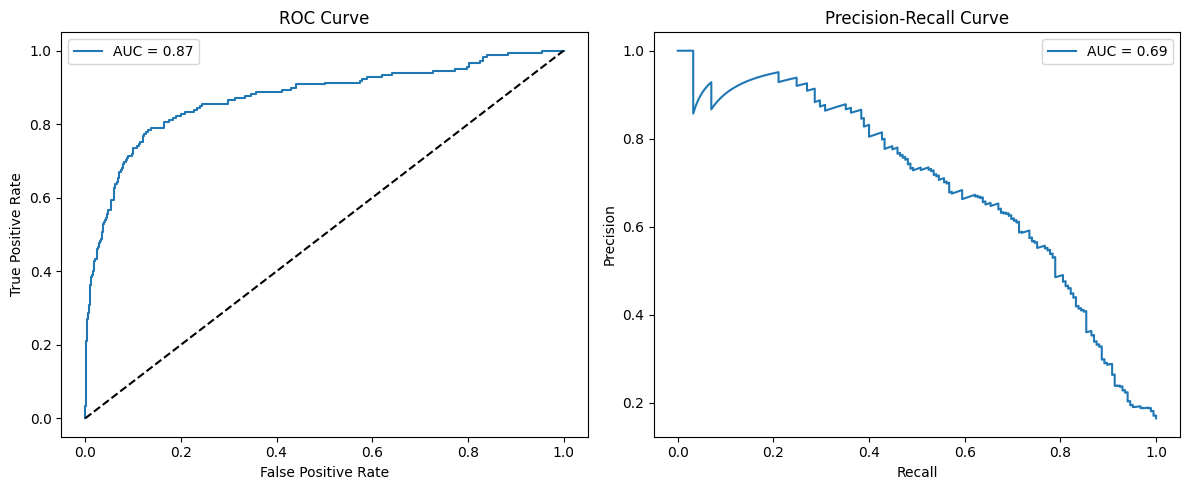

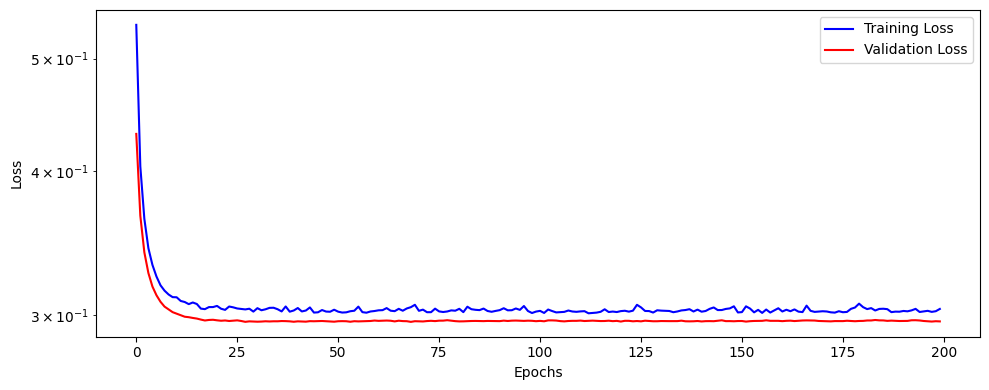

In [6]:
from trainer import Trainer
from predictor import Predictor

trainer = Trainer()
arch, scaler = trainer.train(n_epochs=200)

predictor = Predictor(arch)
predictor.run()
fig = arch.plot_losses()

# 📈 Model Results

## 🔢 Evaluation Metrics

| Metric         | Value |
|----------------|---------|
| Accuracy       | 0.88  |
| Precision      | 0.62  |
| Recall         | 0.71  |
| F1-score       | 0.67  |
| AUC-ROC        | 0.87  |
| AUC-PR         | 0.70  |

## 📌 Confusion Matrix

|                | Predicted 0 | Predicted 1 |
|----------------|-------------|-------------|
| Actual 0       | 861         | 80          |
| Actual 1       | 55          | 130         |

## 📉 Loss Curves

![Loss over Epochs](path/to/your/loss_plot.png)

- The model converges quickly (around epoch 30) and remains stable throughout training.
- There is no significant sign of overfitting, as the training and validation losses stay close.

## 📊 Evaluation Curves

![ROC and PR Curves](path/to/your/roc_pr_plot.png)

- **AUC-ROC = 0.87**: Indicates strong discriminative ability between the classes.
- **AUC-PR = 0.70**: Reasonable performance for the positive class, especially useful in imbalanced datasets.

---

## ✅ Conclusion

- The model has **reasonable precision**, meaning few false positives when predicting the positive class.
- However, the **recall is regular** (71%), which means the model is missing some true positives.

The model performs well overall, showing strong class separation (AUC-ROC), good accuracy and reasonable recall and precision.


In [7]:
%%writefile optimized_trainer.py

import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from architecture import Architecture

class OptimizedTrainer:
    def __init__(self, data_path='clean_data.pkl', batch_size=64, lr=0.001, test_size=0.2, seed=13):
        self.data_path = data_path
        self.batch_size = batch_size
        self.lr = lr
        self.test_size = test_size
        self.seed = seed

        self.scaler = None
        self.model = None
        self.optimizer = None
        self.loss_fn = None
        self.train_loader = None
        self.val_loader = None
        self.arch = None

    def load_data(self):
        with open(self.data_path, 'rb') as f:
            df = pickle.load(f)
        X = df.drop(columns=["Churn"]).values
        y = df["Churn"].values
        return X, y

    def process_data(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=self.seed)
        self.scaler = StandardScaler()
        self.scaler.fit(X_train)
        X_train = self.scaler.transform(X_train)
        X_val = self.scaler.transform(X_val)
        return X_train, X_val, y_train, y_val

    def build_dataloaders(self, X_train, y_train, X_val, y_val):
        x_train_tensor = torch.as_tensor(X_train).float()
        y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()
        x_val_tensor = torch.as_tensor(X_val).float()
        y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

        train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size * 2)

    def build_model(self, input_dim):
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def train(self, n_epochs=50):
        torch.manual_seed(self.seed)

        X, y = self.load_data()
        X_train, X_val, y_train, y_val = self.process_data(X, y)
        self.build_dataloaders(X_train, y_train, X_val, y_val)
        self.build_model(input_dim=X.shape[1])

        self.arch = Architecture(self.model, self.loss_fn, self.optimizer)
        self.arch.set_loaders(self.train_loader, self.val_loader)
        self.arch.set_seed(42)
        self.arch.train(n_epochs=n_epochs)

        return self.arch, self.scaler


Overwriting optimized_trainer.py


# Neural Network Model

Acurácia: 0.9627
Precisão: 0.8265
Recall: 0.9784
F1-score: 0.8960
AUC-ROC: 0.9965
AUC-PR: 0.9869
Matriz de Confusão:
[[903  38]
 [  4 181]]


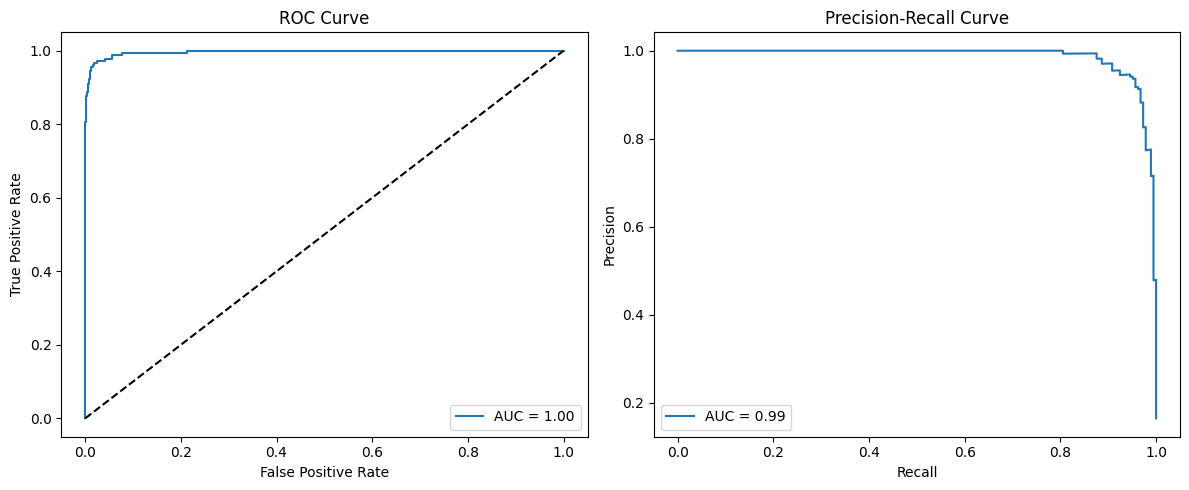

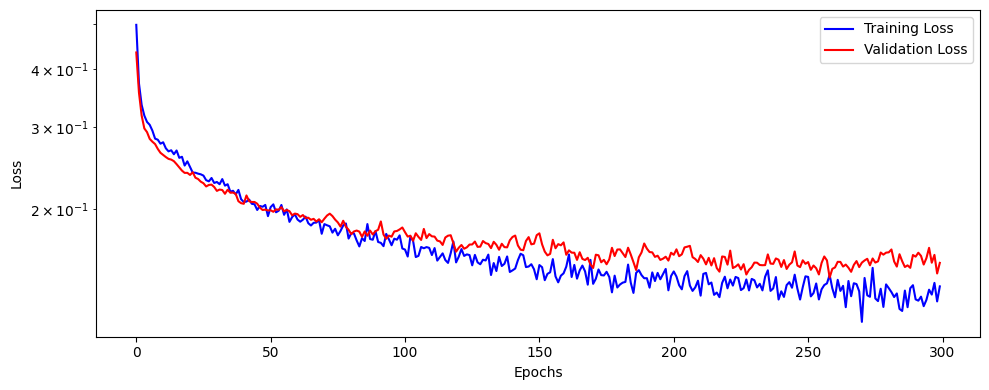

In [12]:
from optimized_trainer import OptimizedTrainer
from predictor import Predictor

trainer = OptimizedTrainer()
arch, scaler = trainer.train(n_epochs=300)

predictor = Predictor(arch)
predictor.run()
fig = arch.plot_losses()

## Neural Network Model Performance Evaluation

The neural network was trained using a custom `OptimizedTrainer` class for 300 epochs. Below are the key performance metrics and visualizations for the binary classification task:

### 🔍 Performance Metrics

| Metric        | Value   |
|---------------|---------|
| **Accuracy**  | 0.9627  |
| **Precision** | 0.8265  |
| **Recall**    | 0.9784  |
| **F1-Score**  | 0.8960  |
| **AUC-ROC**   | 0.9965  |
| **AUC-PR**    | 0.9869  |

These metrics indicate a highly performant model, especially for imbalanced datasets:

- **High Recall (0.9784)** means that the model successfully identifies the vast majority of positive instances (e.g., customers who will churn).
- **High Precision (0.8265)** shows that most of the predicted positives are indeed correct.
- **F1-Score (0.8960)** balances precision and recall, confirming overall robustness.
- **AUC-ROC (0.9965)** and **AUC-PR (0.9869)** close to 1 indicate excellent discrimination capacity between classes.

### 📊 Confusion Matrix

|              | Predicted Negative | Predicted Positive |
|--------------|--------------------|--------------------|
| **Actual Negative** | 903 (TN)           | 38 (FP)            |
| **Actual Positive** | 4 (FN)            | 181 (TP)           |

The confusion matrix shows a **very low number of false negatives**, which is crucial in scenarios where missing a positive case (e.g., a customer who will churn) is costly.

### 📈 Visualizations

#### ROC and Precision-Recall Curves

- The **ROC curve** shows a near-perfect performance with an AUC of **0.9965**.
- The **Precision-Recall curve** indicates strong performance in identifying the minority class, with an AUC of **0.9869**.

#### Loss Curves

The training and validation loss curves demonstrate:

- A smooth and consistent decrease in both training and validation loss.
- No significant overfitting, as the validation loss closely follows the training loss throughout the epochs.

![ROC and PR Curve](./32054a8b-38d8-4b57-a4d5-098ad351f333.png)  
![Second ROC and PR Curve](./dca4759c-2bea-4bb2-813c-bd9fb9193b7b.png)  
![Loss Curve](./609e030b-bae4-4acc-8730-19998cc3e2d9.png)
